In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def impute_nan_with_median(table):
    for col in table.columns:
        table[col]= table[col].fillna(table[col].median())
    return table 

In [3]:
data = pd.read_csv('C:/Users/varvara tihonova/mlcourse.ai/data/credit_scoring_sample.csv', sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


Distribution of target:


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

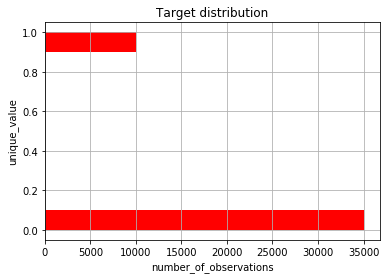

In [4]:
ax = data['SeriousDlqin2yrs'].hist(orientation='horizontal', color='red')
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print('Distribution of target:')
data['SeriousDlqin2yrs'].value_counts(normalize=True) 

In [5]:
independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != 'SeriousDlqin2yrs']
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [6]:
table = impute_nan_with_median(data)

In [7]:
X = table[independent_columns_names]
y = table['SeriousDlqin2yrs']

In [21]:
def get_bootstrap_samples(data, n_samples):
    """Generate bootstrap samples using the bootstrap method."""
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    """Produce an interval estimate."""
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

# Save the data about the loyal and former customers to split the dataset
unpaid = data.loc[data['SeriousDlqin2yrs'] == False,
                               'MonthlyIncome'].values
paid = data.loc[data['SeriousDlqin2yrs'] == True,
                          'MonthlyIncome'].values

# Set the seed for reproducibility of the results
np.random.seed(17)

# Generate the samples using bootstrapping and calculate the mean for each of them
loyal_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(unpaid, 2000)]
churn_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(paid, 2000)]

# Print the resulting interval estimates
print("Service up from unpaid: mean interval", stat_intervals(loyal_mean_scores, 0.20))
print("Service p from paid: mean interval", stat_intervals(churn_mean_scores, 0.20))

Service up from unpaid: mean interval [6310.92322402 6478.45869224]
Service p from paid: mean interval [5486.3783862 5625.3523838]


In [22]:
6310.92322402-5625.3523838

685.5708402199998

In [23]:
# you'll be asked to fix this seed (`random_state`) everywhere in this notebook
SEED = 17

In [304]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score,make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold

In [305]:
dt = DecisionTreeClassifier(random_state=SEED, class_weight='balanced')

In [307]:
max_depth_values = [5, 6, 7, 8, 9]
max_features_values = [4, 5, 6, 7]
tree_params = {'max_depth': max_depth_values,
               'max_features': max_features_values}

In [308]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

In [309]:
tree_grid = GridSearchCV(dt, tree_params,
                         cv=skf,scoring='roc_auc')

In [310]:
tree_grid.fit(X,y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=17, shuffle=True),
             error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=17,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'max_depth': [5, 6, 7, 8, 9],
       

In [311]:
tree_grid.best_params_

{'max_depth': 7, 'max_features': 6}

In [101]:
from sklearn.ensemble import RandomForestClassifier

In [85]:
cross_val_score(tree_grid, X,y,
                         cv=skf,scoring='roc_auc')-tree_grid.best_score_

array([-0.00037514,  0.00108858, -0.00287293, -0.0029061 , -0.00722202])

In [312]:
def addArr(x1, x2):
    for i in range(0, len(x1)):
        x1[i]+=x2[i]

In [96]:
from sklearn.base import BaseEstimator
from sklearn.model_selection import cross_val_score

class RandomForestClassifierCustom(BaseEstimator):
    def __init__(self, n_estimators=10, max_depth=7, max_features=6, 
                 random_state=SEED):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state
        
        self.trees = []
        self.feat_ids_by_tree = []
        
    def fit(self, X, y):
        c=self.n_estimators-1
        for i in range(0,(c)):
            SEED=(self.random_state + i)
            self.feat_ids_by_tree.append(np.random.choice(np.arange(0,7),self.max_features,replace=False))
           
            tree=tree.DecisionTreeClassifier(max_depth=self.max_depth, max_features=self.max_features, random_state=self.random_state )
            trees.append(tree)
        return self
    
    def predict_proba(self, X):
        pred=self.trees[0].predict_proba(X)
        
        for i,el in enumerate(self.trees[1:]):
            addArr(pred, el.predict_proba(X))
            
        for i in range(0, len(pred)):
            pred[i]/=self.n_estimators
        return np.mean(pres)    
            

In [147]:
clf = RandomForestClassifier( class_weight='balanced',n_estimators=10,random_state=17)


In [154]:
clf_G=GridSearchCV(clf, tree_params,
                         cv=skf,scoring='roc_auc')

In [156]:
clf_G.best_score_

0.832090753379093

In [157]:
clf_G.best_params_

{'max_depth': 8, 'max_features': 4}

In [158]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

scaler = StandardScaler()
logit = LogisticRegression(random_state=SEED, solver='liblinear', class_weight='balanced')

logit_pipe = Pipeline([('scaler', scaler), ('logit', logit)])
logit_pipe_params = {'logit__C': np.logspace(-8, 8, 17)}

In [161]:
np.mean(cross_val_score(logit_pipe, X, y,  cv=skf,scoring='roc_auc'))

0.7879805638017383

In [300]:
# Download data
df = pd.read_csv("C:/Users/varvara tihonova/mlcourse.ai/data/movie_reviews_train.csv.zip", nrows=50000)

# Split data to train and test
X_text = df["text"]
y_text = df["label"]

# Classes counts
df.label.value_counts()

1    32492
0    17508
Name: label, dtype: int64

In [208]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

# Split on 3 folds
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=SEED)

# In Pipeline we will modify the text and train Random forest
classifier = Pipeline([
    ('vectorizer', CountVectorizer(max_features=100000, ngram_range=(1, 3))),
    ('clf', RandomForestClassifier(n_estimators=10, random_state=SEED, n_jobs=-1))])

min_samples_leaf = [1, 2, 3]
max_features = [0.3, 0.5, 0.7]
max_depth = [None]

In [187]:
tree_params = {'max_depth': max_depth,
               'max_features': max_features,
              'min_samples_leaf':min_samples_leaf}

In [206]:
cross_val_score(tree, X,y,
                         cv=skf,scoring='roc_auc')

array([0.80942331, 0.80515987, 0.80959512])

In [274]:
from sklearn.pipeline import make_pipeline

In [298]:
# In Pipeline we will modify the text and train logistic regression
classifier = Pipeline([
    ('vectorizer', CountVectorizer(max_features=100000, ngram_range=(1, 3))),
    ('clf', LogisticRegression(solver='liblinear', random_state=SEED))])

parameters = {'clf__C': (0.1, 1, 10, 100)}

In [301]:
clf_G=GridSearchCV(estimator=classifier,param_grid=parameters,
                         cv=skf,scoring='roc_auc',n_jobs=-1,verbose=True)
clf_G.fit(X_text, y_text)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:  1.5min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=17, shuffle=True),
             error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vectorizer',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=100000,
                                                        min_df=1,
                                          

In [233]:
#cross_val_score(tree_grid, X,y,
 #                        cv=skf,scoring='roc_auc')
from sklearn.model_selection import cross_val_score    
from sklearn.model_selection import train_test_split

In [303]:
np.mean(cross_val_score(clf_G, X_text,y_text,
                         cv=skf,scoring='roc_auc',n_jobs=-1,verbose=True))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.3min finished


0.8600950683192753